# 导入部分

In [1]:
import torch
import torch.nn as nn
import torch.cuda
import new_model
import dgl

In [2]:
import os
os.environ['KMP_DUPIPLICATE_LIB_OK']='True'

# 辅助动图类

In [3]:
%matplotlib inline
from IPython import display
from matplotlib import pyplot as plt
from matplotlib_inline import backend_inline

class Animator:
    """在动画中绘制数据"""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        # 增量地绘制多条线
        if legend is None:
            legend = []
        backend_inline.set_matplotlib_formats('svg')
        self.fig, self.axes = plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # 使用lambda函数捕获参数
        self.config_axes = lambda: self.set_axes(xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def set_axes(self, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
        """设置matplotlib的轴"""
        self.axes[0].set_xlabel(xlabel)
        self.axes[0].set_ylabel(ylabel)
        self.axes[0].set_xscale(xscale)
        self.axes[0].set_yscale(yscale)
        self.axes[0].set_xlim(xlim)
        self.axes[0].set_ylim(ylim)
        if legend:
            self.axes[0].legend(legend)
        self.axes[0].grid()


    def add(self, x, y):
        # 向图表中添加多个数据点
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        plt.draw()
        plt.pause(0.001)
        display.display(self.fig)
        display.clear_output(wait=True)
        
    def show(self):
        display.display(self.fig)

# 训练和评估函数

In [4]:
def eval(val_graph_list, model, loss_func, device, batch_size):
    model.eval()
    with torch.no_grad():
        val_loss = []
        for i in range(0, len(val_graph_list), batch_size):
            batch_graphs = val_graph_list[i:i + batch_size]
            
            # 创建批处理图对象
            batched_graph = dgl.batch(batch_graphs)
            batched_graph = batched_graph.to(device)
            
            active_index, consume_index = model(batched_graph)
            label = batched_graph.ndata['label'].float()
            
            loss = loss_func(active_index,label[:,0]) + loss_func(consume_index,label[:,1])
            val_loss.append(loss.item())
        model.train()
        val_loss = sum(val_loss) / len(val_loss)
    return val_loss

In [5]:
def train(graph_list, model, loss_func, optimizer, num_epochs, device, train_ratio, batch_size):
    
    # 划分训练集和验证集
    train_graph_list = graph_list[:int(len(graph_list) * train_ratio)]
    val_graph_list = graph_list[int(len(graph_list) * train_ratio):]
    
    # 将数据集放到device上
    loss_func = loss_func.to(device)
    train_graph_list = [graph.to(device) for graph in train_graph_list]
    val_graph_list = [graph.to(device) for graph in val_graph_list]
    
    animator = Animator(xlabel='epoch', ylabel='loss', xlim=[0, num_epochs], ylim=[0,150], legend=['train loss', 'val loss', 'score'])

    
    model.train()
    
    for epoch in range(num_epochs):
        train_loss = []
        
        for i in range(0, len(train_graph_list), batch_size):
            batch_graphs = train_graph_list[i:i + batch_size]
            
            # 创建批处理图对象
            batched_graph = dgl.batch(batch_graphs)
            
            # 将批处理图对象放到device上
            # batched_graph = batched_graph.to(device)
            
            # 前向传播
            active_index, consume_index = model(batched_graph)
            
            # 计算损失
            label = batched_graph.ndata['label'].float()
            loss = loss_func(active_index, label[:, 0]) + loss_func(consume_index, label[:, 1])
            
            train_loss.append(loss.item())
            
            # 反向传播
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        # 计算平均损失
        train_loss = sum(train_loss) / len(train_loss)
        
        # 使用评估函数计算验证集上的loss
        val_loss = eval(val_graph_list, model, loss_func, device, batch_size=3)
        
        # 对val_loss开根号
        sqrt_val_loss = torch.sqrt(torch.tensor(val_loss * 4))
        
        # 计算score
        score = 1 / (1 + sqrt_val_loss)
        
        # 打印损失和score
        print('Epoch: {0}\n Train loss: {1}\n Dev loss: {2}\n Score: {3}'.format(epoch + 1, train_loss, val_loss, score))
        
        # 绘制动画
        animator.add(epoch + 1,(train_loss, val_loss, score * 1000))
    
        if epoch + 1 % 5 == 0:

            # 打印损失和score
            print('Epoch: {0}\n Train loss: {1}\n Dev loss: {2}\n Score: {3}'.format(epoch + 1, train_loss, val_loss, score))
            
            # 绘制动画
            animator.add(epoch + 1,(train_loss, val_loss, score * 1000))

# 执行部分

In [6]:
# 读取dgl图训练集
graph_list, _ = dgl.load_graphs('dgl_data/dgl_graphs_train.bin')

In [7]:
# 将graph_list中的图转换为无向图
for graph in graph_list:
    graph = dgl.to_bidirected(graph)

In [8]:
# GAT_1参数
# num_heads = 8
# num_hidden = 120
# dropout = 0.2
# alpha = 0.3
# num_epochs = 250
# train_ratio = 0.9
# learning_rate = 0.0003
# loss_func = nn.MSELoss()

In [9]:
# GCN_1参数
# num_epochs = 1000
# train_ratio = 0.8
# learning_rate = 0.0002
# loss_func = nn.MSELoss()

In [10]:
# GAT_2参数
num_epochs = 1000
train_ratio = 0.9
learning_rate = 0.0003
loss_func = nn.MSELoss()

In [11]:
# GAT_3参数
# num_epochs = 250
# train_ratio = 0.9
# learning_rate = 0.0005
# loss_func = nn.MSELoss()

In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [13]:
# model = new_model.GAT_1(in_feature=33, edge_feature=2, num_heads=num_heads, num_hidden=num_hidden, dropout=dropout, alpha=alpha).to(device)

In [14]:
# model = new_model.GCN_1(in_feature=33).to(device)

In [15]:
model = new_model.GAT_2(in_feature=33).to(device)

In [16]:
# model = new_model.GAT_3(in_feature=33).to(device)

In [17]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

Epoch: 1000
 Train loss: 85.99934823172433
 Dev loss: 95.96495564778645
 Score: 0.04856174439191818


<Figure size 640x480 with 0 Axes>

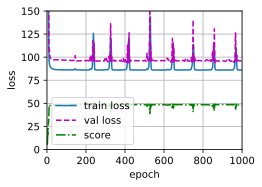

In [18]:
train(graph_list, model, loss_func, optimizer, num_epochs, device, train_ratio, batch_size=12)

In [19]:
# 使用当前的时间作为文件名来保存模型
import time
t = time.localtime()
torch.save(model.state_dict(), 'model/model_{}_{}_{}_{}.pth'.format(t.tm_mon, t.tm_mday, t.tm_hour, t.tm_min))

In [20]:
# 读取dgl图测试集
# test_graph_list, _ = dgl.load_graphs('dgl_data/dgl_graphs_test.bin')

In [21]:
# 读取模型
# model = new_model.GAT(in_feature=33)
# model.load_state_dict(torch.load('model/gat_model.pth'))

In [22]:
# 将graph_list中的图转换为无向图
# for graph in test_graph_list:
#     graph = dgl.to_bidirected(graph)